In [29]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

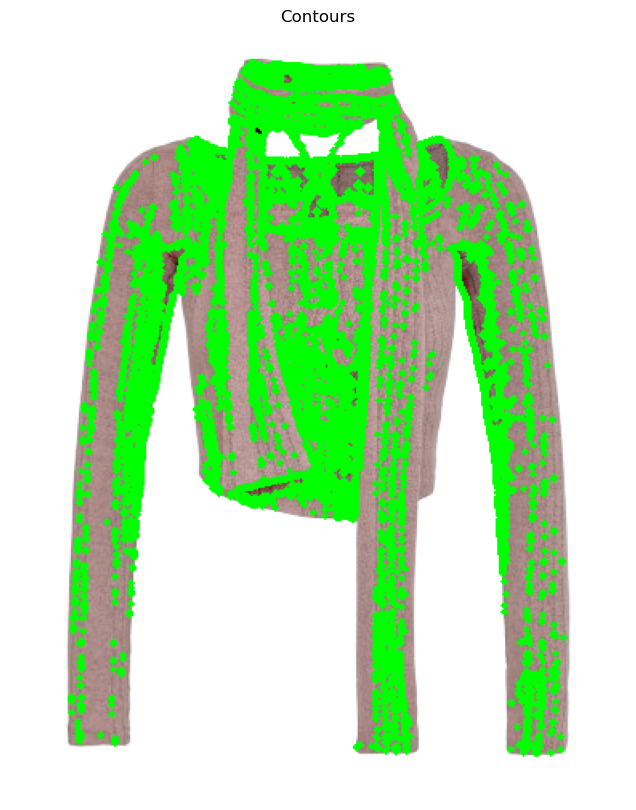

In [30]:
# 이미지를 불러옵니다. 여기서는 '옷.png'를 사용합니다.
# 주의: imread는 실행하는 .ipynb 파일과 같은 디렉토리에 있는 이미지 파일을 불러옵니다.
# 다른 경로에 있는 파일은 해당 경로를 정확히 지정해야 합니다.
img = cv.imread('clothes/pink_tea-removebg-preview.png')

# 이미지를 그레이스케일로 변환합니다.
gray = cv.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 이진화를 진행합니다. 임계값을 설정하여 그레이스케일 이미지를 이진 이미지로 변환합니다.
_, binary = cv.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# 컨투어를 찾습니다.
contours, hierarchy = cv.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# 컨투어를 원본 이미지에 초록색으로 그립니다.
cv.drawContours(img, contours, -1, (0, 255, 0), 3)

# 이미지를 RGB로 변환합니다. (OpenCV는 BGR을 사용합니다.)
img_rgb = cv.cvtColor(img, cv2.COLOR_BGR2RGB)

# 결과를 표시합니다.
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title('Contours')
plt.axis('off')
plt.show()


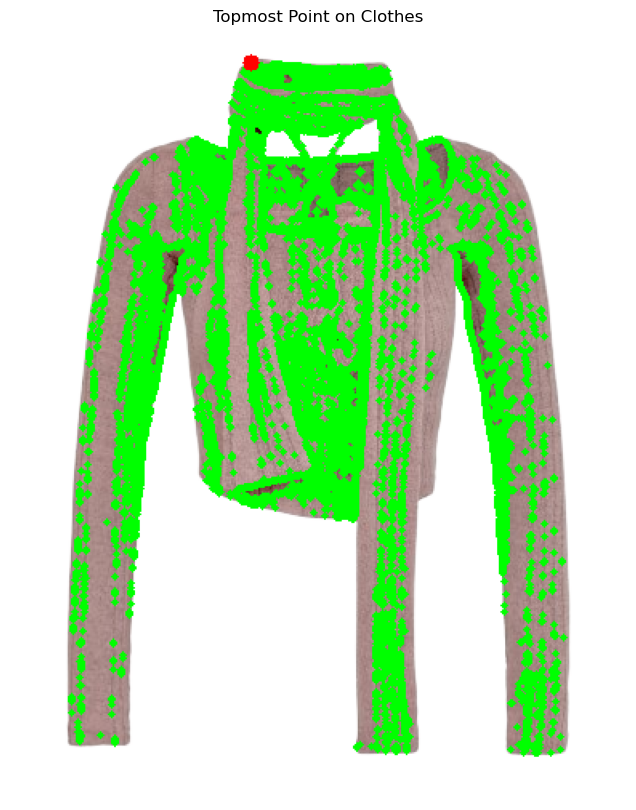

In [31]:
# 옷의 최상단 좌표를 찾습니다.
# 컨투어 포인트들 중 y 값이 최소인 포인트를 최상단 좌표로 합니다.
topmost = tuple(contours[0][contours[0][:,:,1].argmin()][0])
for contour in contours:
    # 각 컨투어마다 최상단 포인트를 찾습니다.
    current_topmost = tuple(contour[contour[:,:,1].argmin()][0])
    # 더 위에 있는 포인트를 최상단 좌표로 갱신합니다.
    if current_topmost[1] < topmost[1]:
        topmost = current_topmost

# 최상단 좌표에 빨간색 점을 그립니다.
cv.circle(img_rgb, topmost, 5, (255, 0, 0), -1)

# 결과를 다시 표시합니다.
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title('Topmost Point on Clothes')
plt.axis('off')
plt.show()


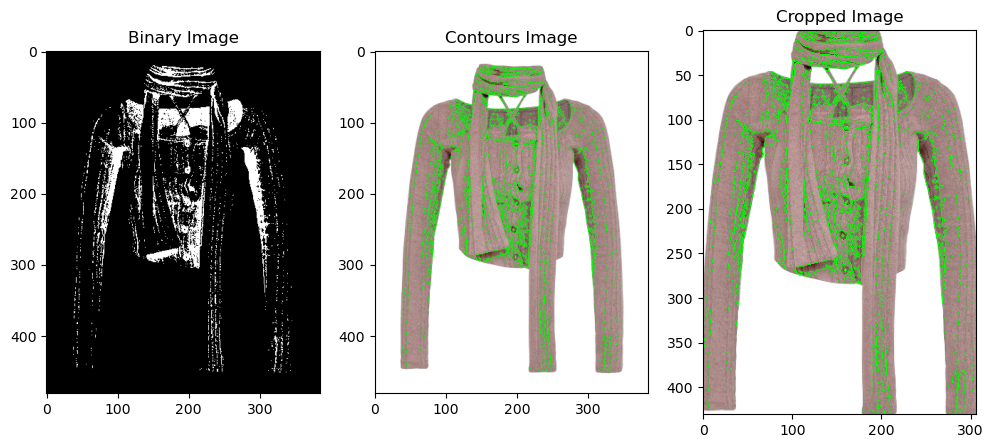

In [37]:
def process_image(img_path, threshold_val=127):
    # 이미지 로드
    img_color = cv.imread(img_path)
    img_gray = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)
    
    # 이진화
    ret, img_binary = cv.threshold(img_gray, threshold_val, 255, cv.THRESH_BINARY_INV)
    
    # 모폴로지 연산을 위한 커널
    kernel = np.ones((1,1), np.uint8)
    
    # 모폴로지 연산
    img_mask = cv.morphologyEx(img_binary, cv.MORPH_OPEN, kernel)
    img_mask = cv.morphologyEx(img_binary, cv.MORPH_CLOSE, kernel)
    
    # 윤곽선 검출
    contours, hierarchy = cv.findContours(img_binary, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    
    # 윤곽선 그리기
    cv.drawContours(img_color, contours, -1, (0, 255, 0), 1)
    
    # 윤곽선을 이용한 최소/최대 x, y 값 계산
    x_min, y_min = np.inf, np.inf
    x_max, y_max = -np.inf, -np.inf
    for contour in contours:
        for point in contour:
            x, y = point[0]
            x_min = min(x, x_min)
            x_max = max(x, x_max)
            y_min = min(y, y_min)
            y_max = max(y, y_max)
    
    # 관심 영역(ROI) 자르기
    img_crop = img_color[y_min:y_max, x_min:x_max]
    
    # 결과 이미지 저장
    img_name = "crop_1.png"
    cv.imwrite(img_name, img_crop)
    
    # 결과 출력
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(cv.cvtColor(img_binary, cv.COLOR_GRAY2RGB))
    plt.title('Binary Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv.cvtColor(img_color, cv.COLOR_BGR2RGB))
    plt.title('Contours Image')

    plt.subplot(1, 3, 3)
    plt.imshow(cv.cvtColor(img_crop, cv.COLOR_BGR2RGB))
    plt.title('Cropped Image')
    
    plt.show()

process_image('clothes/pink_tea-removebg-preview.png', 127)


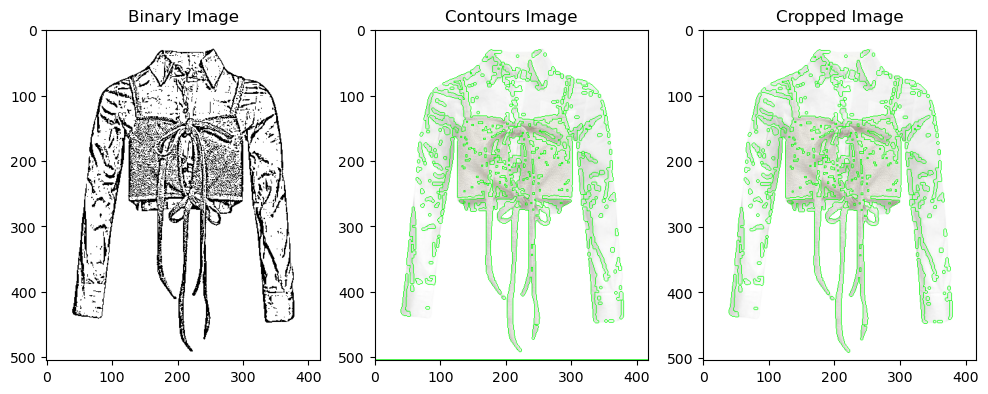

In [40]:
def process_image(img_path, block_size=11, C=2):
    # 이미지 로드
    img_color = cv.imread(img_path)
    img_gray = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)
    
    # 적응적 이진화 사용
    img_binary = cv.adaptiveThreshold(img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                      cv.THRESH_BINARY, block_size, C)
    
    # 모폴로지 연산을 위한 커널 크기 조정
    kernel = np.ones((3,3), np.uint8)
    
    # 모폴로지 연산
    img_mask = cv.morphologyEx(img_binary, cv.MORPH_OPEN, kernel)
    img_mask = cv.morphologyEx(img_mask, cv.MORPH_CLOSE, kernel)
    
    # 윤곽선 검출
    contours, hierarchy = cv.findContours(img_mask, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    
    # 윤곽선 그리기
    cv.drawContours(img_color, contours, -1, (0, 255, 0), 1)
    
    # 윤곽선을 이용한 최소/최대 x, y 값 계산
    x_min, y_min = np.inf, np.inf
    x_max, y_max = -np.inf, -np.inf
    for contour in contours:
        for point in contour:
            x, y = point[0]
            x_min = min(x, x_min)
            x_max = max(x, x_max)
            y_min = min(y, y_min)
            y_max = max(y, y_max)

    # 관심 영역(ROI) 자르기
    img_crop = img_color[y_min:y_max, x_min:x_max]

    img_name = "crop.png"
    cv.imwrite(img_name, img_crop)

    # 결과 출력
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(cv.cvtColor(img_binary, cv.COLOR_GRAY2RGB))
    plt.title('Binary Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv.cvtColor(img_color, cv.COLOR_BGR2RGB))
    plt.title('Contours Image')

    plt.subplot(1, 3, 3)
    plt.imshow(cv.cvtColor(img_crop, cv.COLOR_BGR2RGB))
    plt.title('Cropped Image')
    
    plt.show()

# 함수 사용 예시
process_image('clothes/white_shirts.png')